In [139]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Explore the data

### 1)a) Load in the data:

In [140]:
#load in the text file:
with open("SMSSpamCollection.txt") as f:
    content = f.readlines()
#initialize emty list that later will be transformed to final data frame:
l = []
#loop trhough lines, get rid of new line signs and save in list:
for line in content:
    line = line.strip("\n")
    c = line.split("\t")
    l.append(c)
#transform list to df:
df = pd.DataFrame.from_records(l)
#rename columns:
df.columns = ["class","sms"]
#change ham to 0 and spam to 1
ind = df.loc[:,"class"]=="ham"
df.loc[ind,"class"] = 0
df.loc[-ind,"class"] = 1
#print the head of the df:
df.head(40)


,class,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


### 1b) Basic analysis on data set before cleaning:

(5574, 2)
False


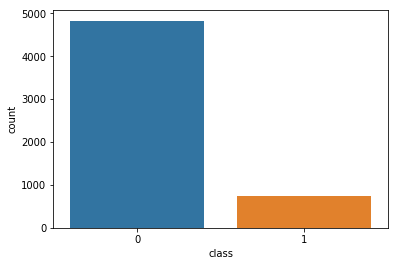

In [141]:
print(df.shape)
#check for Nas:
print(df.isnull().values.any())
#generate a count plot:
sns.countplot(x="class",data=df)


The df has 5574 rows and 2 columns (i.e. is it a spam or not and the content of the sms). The data set contains no NA's, so the reading of the file was successful. We can see that the data set is unbalanced with +/- 4800 sms being not spam, and around 800 sms being spam.

Lets check for doubles in the data:

In [142]:
print('Number of SMS:', df.sms.count())
print('Number of unique SMS: ', df.sms.nunique())


Number of SMS: 5574
Number of unique SMS:  5171


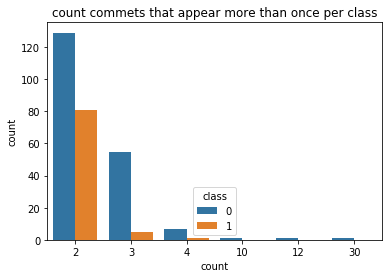

In [143]:
#Are the non-unique sms rather spam?

#set index to group on indexes:
df.set_index(['class','sms'],inplace=True)
#group by and get a count column:
df2 = pd.DataFrame(df.groupby(["sms","class"]).size())
df2.reset_index(inplace=True)
#get index of count larger than 1:
i = df2.iloc[:,2] > 1
df2.columns=["sms","class","count"]
df2 = df2[i]
#generate count plot:
sns.countplot(x="count",hue="class",data=df2)
plt.title('count commets that appear more than once per class')
plt.show()


#reset the index for the main data frame:
df.reset_index(inplace=True)

Lets check the distribution of the length of SMS, once in general, then for spams and not spams and see if we can get a conclusion out of this:

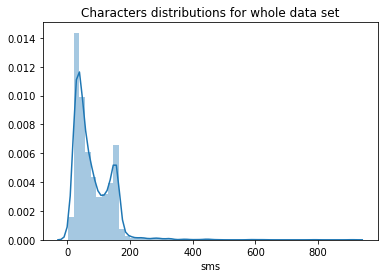

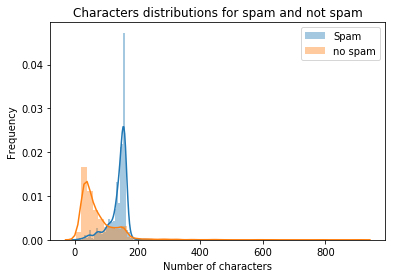

In [144]:
#distribution of comment lengths:

#whole data set:
sns.distplot(df['sms'].apply(len))
plt.title('Characters distributions for whole data set')
plt.show()

#spam:
ind = df.loc[:,"class"]==1
df_spam=df[ind]
sns.distplot(df_spam['sms'].apply(len),label="Spam")
#not spam:
df_not_spam=df[-ind]
ax = sns.distplot(df_not_spam['sms'].apply(len),label="no spam")
plt.legend()
plt.title('Characters distributions for spam and not spam')
ax.set(xlabel='Number of characters', ylabel='Frequency')
plt.show()



We can observe that the spam sms are longer on average, so it might be interesting to include the length of the sms as a feature.

We might be interested to see if there is a phone number in a sms. A simple idea is to count hte number of single digits in a sms, and if the number is larger then 8, the probability is high that it is a phone number (an adress for example should have less than 8 digits). As a result, we need to come up with a function counting the digits in each sms:

In [158]:
#SMS digit count 
# creating a list with all reviews
sms = df.sms.tolist()
#empty list to save counts:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c.isdigit():
            count = count + 1
    count_list.append(count)
    
#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()
df2['digit_count'] = count_list
phone = (df2.loc[:,'digit_count'] > 8)
df2['phone'] = phone
df2.head()


,class,sms,digit_count,phone
0,0,"Go until jurong point, crazy.. Available only ...",0,False
1,0,Ok lar... Joking wif u oni...,0,False
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,25,True
3,0,U dun say so early hor... U c already then say...,0,False
4,0,"Nah I don't think he goes to usf, he lives aro...",0,False


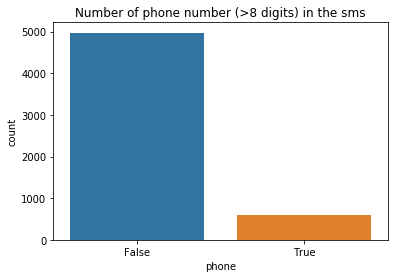

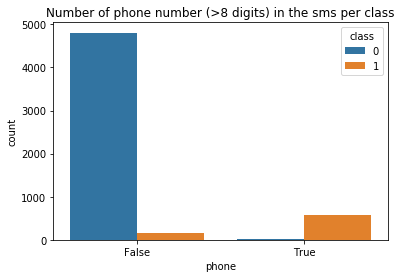

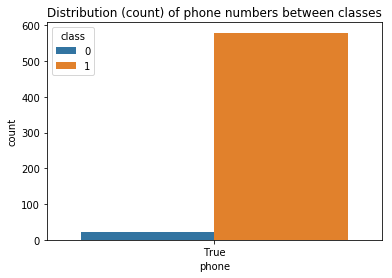

In [146]:
#make a count plot with phone numbers:
sns.countplot(x="phone",data=df2)
plt.title('Number of phone number (>8 digits) in the sms')
plt.show()

#count phone numbers per class:
sns.countplot(x="phone",hue="class",data=df2)
plt.title('Number of phone number (>8 digits) in the sms per class')
plt.show()

#look precisely at phone numbers for different classes:
ind = (df2.loc[:,"phone"] == True)
df3 = df2[ind]
sns.countplot(x="phone",hue="class",data=df3)
plt.title('Distribution (count) of phone numbers between classes')
plt.show()


We get a very interesting insight from analysing phone numbers.

1) about 4900 sms's have not more than 8 digits (i.e. no phone numbers)  
2) around 600 sms's have a phone number in the text  
3) out of those 600, about 570 are marked as spam, only about 30 are not spam

As such, having more than 8 digits in the content might be a strong indicator for a spam sms.

Next, we might be interested to count upper case letters. The underlying assumption is that spam sms's might use upper case to attract attention, while normal sms's might use a lot less upp-case letters.

In [147]:
#count upper-case:
count_list = []
for s in sms:
    count = 0
    for c in s:
        if c.isupper():
            count = count + 1
    count_list.append(count)
count_list

#transform to series and add to df2 (which is a copy of df):
count_list = pd.Series(count_list)

df2 = df.copy()
df2['digit_count'] = count_list

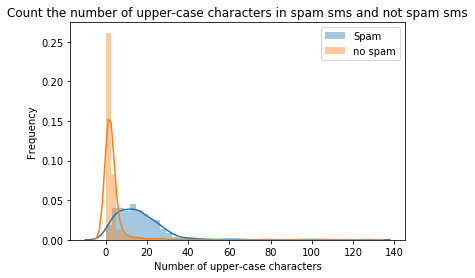

In [148]:
#spam:
ind = df2.loc[:,"class"]==1
df_spam=df2[ind]
sns.distplot(df_spam.loc[:,'digit_count'],label="Spam")

#not spam:
df_not_spam=df2[-ind]
ax = sns.distplot(df_not_spam.loc[:,'digit_count'],label="no spam")
plt.legend()
plt.title('Count the number of upper-case characters in spam sms and not spam sms')
ax.set(xlabel='Number of upper-case characters', ylabel='Frequency')
plt.show()



While a lot of normal sms seem to have none upper-case characters, the spam emails tend to have more upper-case characters, which seems to confirm our. It might be a good idea to include the number of upper-case characters as a feature in our model.

TO DO 
before cleaning, as it might be of interests for features:

    1) number of special charcters in spam and not spam
    2) smileys (how can we detect them)?
    3) telephone numbers (DONE)
    4) hyperlinks
    5) count upper case characters (spam might use upper case to attract attention) (DONE)
    6) most frquent words in general, spam and not spam - after cleaning

### 1c) Conclusion of data analysis before cleaning:

The main conclusions of the data analysis are as follows:
    
1)Data set contains around 5600 sms  
2)Unbalanced data set, i.e. 800 spam, 4800 not spam  
3)Spam sms tend to be longer than not spam sms  
4)Around 600 sms contain phone number, almost all are spam  
5)Spam sms tend to have more upper-case letters than non-spam sms  

# 2) Clean the data:

###  2)a) Extract some features before cleaning:

For the final algorithm, we might want to extract some features based on special characters (before cleaning the data). This should be done in this section.

In [149]:
#### EXTRACT FEATURES BEFORE CLEANING

In [150]:
#### EXTRACT FEATURES BEFORE CLEANING

In [151]:
 #### EXTRACT FEATURES BEFORE CLEANING

### 2)b) Cleaning & Preprocessing:

In [152]:
# creating a list with all reviews
sms = df.sms.tolist()

In [153]:
# transformating comments into lower-case text 
sms = [text.lower() for text in sms]

### 2)c)i) Additional analytics after cleaning

In [154]:
### SOME ANALYTICS

In [155]:
### SOME ANALYTICS

### 2)c)ii) Results of analytics after cleaning

In [156]:
### CONCLUSION

In [157]:
### EXPORT FILES FOR ALGORITHMS

In [ ]:
print("Okay, you can merge!")